# Imports

In [4]:
import pickle
import json
from __future__ import division
import warnings
warnings.filterwarnings('ignore')
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from numpy.random import randint
from numpy.random import rand
import multiprocessing as mp
import random
import math
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from tqdm.contrib.concurrent import process_map
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Input,Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D, BatchNormalization,LSTM,Bidirectional
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D,UpSampling1D, Conv1DTranspose,GaussianNoise 
from keras.utils import np_utils
from keras import backend as K
from keras.callbacks import Callback
from keras.regularizers import l2 , l1, l1_l2
import tensorflow.keras.backend as kb
print('keras version ', keras.__version__)

from keras.utils.vis_utils import plot_model

keras version  2.9.0


In [5]:
sys.path.append("../src")
from convertor import convert
from preprocessing import get_target, preprocessing

# Functions

In [6]:
def df_to_fasta(df, path):
    lines = []
    df.apply(lambda row: lines.append(f">{row['tag']}\n{row['data']}\n"),axis=1)
    with open(path,'w') as file:
        file.write(''.join(lines))

In [7]:
def fasta_to_df(path):
    with open(path, 'r') as file:
        text = file.read()
    lines = [line for line in text.split('\n') if len(line) > 0]
    s = ''
    tags = []
    data = []
    for l in lines:
        if(l[0]=='>'):
            tags.append(l)        
            data.append(s)
            s = ''
        else:
            s += l    
    data.append(s)
    df = pd.DataFrame(
            {
                'tag': tags,
                'data': data[1:]
            })
    df['tag'] = df['tag'].apply(lambda x: x[1:])    
    return df

In [8]:
class DotDict(dict):
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [9]:
def confusion_matrix(validations, predictions, LABELS):            
    freq = metrics.confusion_matrix(validations, predictions)        
    sensitivity =  (np.divide(freq.transpose(),
                             np.sum(freq, axis=1)).transpose() * 100).round(2)    
    annotation = []
    for i in range(freq.shape[0]):
        row = []
        for j in range(freq.shape[1]):
            row.append(f'{freq[i][j]}\n {sensitivity[i][j]}%')            
        annotation.append(row)
    annotation = np.array(annotation)
    sns.heatmap(sensitivity, cmap="YlOrBr",
                vmin=0, vmax=100,
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=annotation,
               fmt=':<')    
    plt.title("Confusion Matrix")
    plt.ylabel("Actually Label")
    plt.xlabel("Predicted Label")
    plt.show()            

def report(pred, df, ref):
    number_of_hit = len(df['hit seq'].unique())
    print(f'number of unique hit: {number_of_hit}')
    total = len(df[df['hit seq'].isin(ref['data'])]['hit seq'].unique()) 
    print(f'total mir: {total}')    
    selected = df[pd.Series(pred).apply(lambda x: True if x==1 else False)]
    found_seq = selected[selected['hit seq'].isin(ref['data'])]['hit seq'].unique()
    found = len(found_seq)
    print(f'found mir : {found}')
    print(f'fount to all : {round(found / total * 100, 2)}%')
    fp = len(selected[~selected['hit seq'].isin(ref['data'])]['hit seq'].unique())
    print(f'fp: {fp}')

# Load all plant dataset

In [10]:
data               = {}
data["O.sativa"]   = {}
data["A.thaliana"] = {}
data["C.Sinensis"] = {}
data["Z.mays"]     = {}

In [11]:
def load(plant, mu=None, std=None):
    global data
    posX = pd.read_csv(f"../Experiment/{plant}_positive/Result/result_level1_filter.csv")
    posX = convert(posX)    
    posY = np.ones(posX.shape[0], dtype='float32')
    posY = np_utils.to_categorical(posY, 2)
    
    negX = pd.read_csv(f"../Experiment/{plant}_negative/Result/result_level1_filter.csv")
    negX = convert(negX)    
    negY = np.zeros(negX.shape[0], dtype='float32')
    negY = np_utils.to_categorical(negY, 2)        
    Y = np.concatenate([posY, negY])        
    X = pd.concat([posX, negX]).reset_index(drop=True)
    [feature, mu, std] = preprocessing(X, mu, std)    
    data[plant]['feature'] = feature
    data[plant]['target'] = Y
    return [mu, std]

In [9]:
#with open('filename.pickle', 'wb') as handle:
#   pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

#with open('filename.pickle', 'rb') as handle:
    #data = pickle.load(handle)

## O.sativa

In [12]:
[mu, std] = load(plant="O.sativa")

## A.thaliana

In [13]:
load(plant="A.thaliana", mu=mu, std=std);

## C.sinensis

In [14]:
load(plant="C.Sinensis", mu=mu, std=std);

## Z.mays

In [15]:
load(plant="Z.mays", mu=mu, std=std);

# Train Test split and class weight

In [16]:
X = pd.concat([
    data['O.sativa']['feature'],
    data['A.thaliana']['feature'],
    #data['C.Sinensis']['feature'],
    #data['Z.mays']['feature'],        
]).reset_index(drop=True)
Y = np.concatenate([
    data['O.sativa']['target'],                    
    data['A.thaliana']['target'], 
    #data['C.Sinensis']['target'],
    #data['Z.mays']['target'],
])        
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.33, random_state=0)

In [17]:
class_weight = {0: 1.,
                1: (sum(y_train[:,0]) + sum(y_val[:,0])) / (sum(y_train[:,1]) + sum(y_val[:,1]))}
class_weight

{0: 1.0, 1: 18.258007898200965}

# ML

In [31]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

In [ ]:
X = data['O.sativa']['feature']
Y = np.argmax(data['O.sativa']['target'], axis=1)

 d = 46


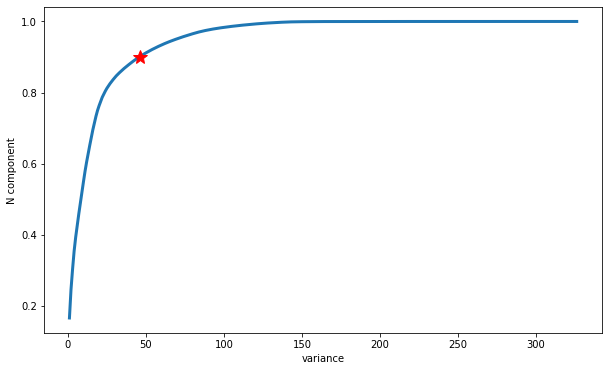

In [32]:
pca = PCA(n_components=X.shape[1])
pca.fit_transform(X)
cumsum = pca.explained_variance_ratio_.cumsum()
d = np.where(cumsum>=0.9)[0][0] + 1
print(f' d = {d}')

plt.figure(figsize=(10,6))
plt.plot(range(1,len(cumsum)+1), cumsum, linewidth=3)
plt.plot(d, cumsum[d-1],'r*',markersize=15)
plt.xlabel("variance")
plt.ylabel("N component")
plt.show()

In [33]:
pca = PCA(n_components=53)
X_pca = pca.fit_transform(X)

In [35]:
'''
scores = []
kfold = KFold(n_splits=3, shuffle=True, random_state=1)
for train_ix, test_ix in kfold.split(X_pca):
    X_train = X_pca[train_ix,:]
    X_test  = X_pca[test_ix,:] 
    y_train = Y[train_ix]
    y_test  = Y[test_ix]
    clf = svm.SVC(kernel="poly", class_weight=class_weight)    
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    f1 = f1_score(y_test, pred, average='macro')
    print(f1)
    scores.append(f1)     
'''

'\nscores = []\nkfold = KFold(n_splits=3, shuffle=True, random_state=1)\nfor train_ix, test_ix in kfold.split(X_pca):\n    X_train = X_pca[train_ix,:]\n    X_test  = X_pca[test_ix,:] \n    y_train = Y[train_ix]\n    y_test  = Y[test_ix]\n    clf = svm.SVC(kernel="poly", class_weight=class_weight)    \n    clf.fit(X_train, y_train)\n    pred = clf.predict(X_test)\n    f1 = f1_score(y_test, pred, average=\'macro\')\n    print(f1)\n    scores.append(f1)     \n'

# Deep learning model

In [18]:
print(X_train.shape[1])
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='relu'))
model.add(Dense(2, activation='softmax'))
print(model.summary())

326
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               83712     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 4)              

In [19]:
callbacks_list = [
                  tf.keras.callbacks.EarlyStopping( monitor="val_loss", patience=5, restore_best_weights=True),
                 ]
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate)
#optimizer = tf.keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0)


model.compile(loss = "categorical_crossentropy",                
                optimizer=optimizer,
                metrics = ["acc"])                
BATCH_SIZE = 32
EPOCHS = 100
history = model.fit(X_train,
                    y_train,
                    class_weight=class_weight,
                    batch_size=BATCH_SIZE,
                    validation_data=(X_val, y_val),
                    epochs=EPOCHS,
                    callbacks=callbacks_list,
                    verbose=1) 

json.dump(str(history.history), open(f"./history.pkl", "w"))
model.save(f'./Model.h5')

Epoch 1/100
919/919 [==============================] - 7s 6ms/step - loss: 0.7149 - acc: 0.9001 - val_loss: 0.2785 - val_acc: 0.9236
Epoch 2/100
919/919 [==============================] - 5s 5ms/step - loss: 0.4346 - acc: 0.9451 - val_loss: 0.1660 - val_acc: 0.9532
Epoch 3/100
919/919 [==============================] - 5s 5ms/step - loss: 0.3448 - acc: 0.9544 - val_loss: 0.1738 - val_acc: 0.9640
Epoch 4/100
919/919 [==============================] - 5s 5ms/step - loss: 0.2766 - acc: 0.9619 - val_loss: 0.0844 - val_acc: 0.9800
Epoch 5/100
919/919 [==============================] - 5s 5ms/step - loss: 0.2368 - acc: 0.9644 - val_loss: 0.0966 - val_acc: 0.9723
Epoch 6/100
919/919 [==============================] - 5s 5ms/step - loss: 0.2015 - acc: 0.9662 - val_loss: 0.0602 - val_acc: 0.9809
Epoch 7/100
919/919 [==============================] - 5s 5ms/step - loss: 0.1859 - acc: 0.9713 - val_loss: 0.0530 - val_acc: 0.9859
Epoch 8/100
919/919 [==============================] - 5s 5ms/step - 

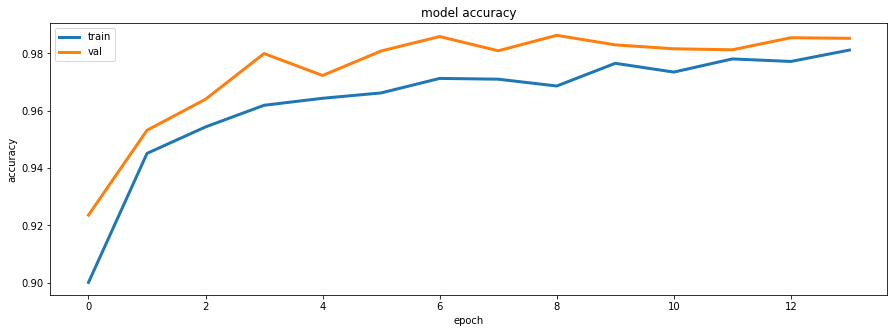

In [20]:
plt.figure(figsize=(15, 5))
plt.plot(history.history['acc'], linewidth=3)
plt.plot(history.history['val_acc'], linewidth=3)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

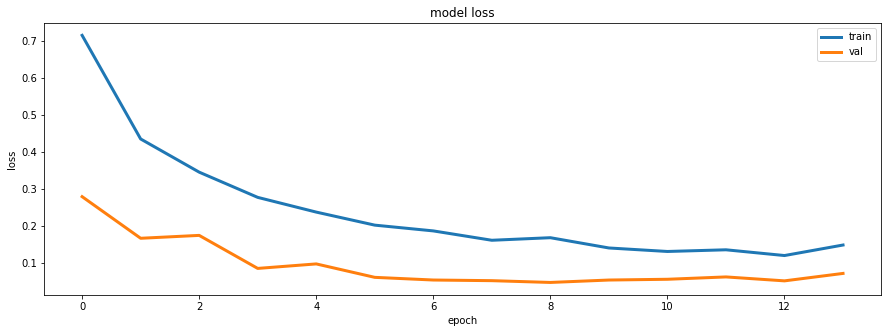

In [21]:
plt.figure(figsize=(15, 5))
plt.plot(history.history['loss'], linewidth=3)
plt.plot(history.history['val_loss'], linewidth=3)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

# O.sativa

1020/1020 [==============================] - 2s 2ms/step


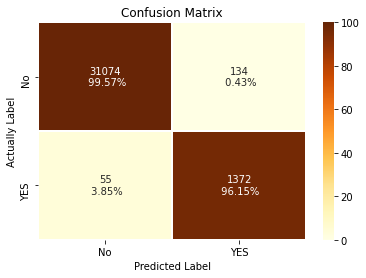

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     31208
           1       0.91      0.96      0.94      1427

    accuracy                           0.99     32635
   macro avg       0.95      0.98      0.97     32635
weighted avg       0.99      0.99      0.99     32635



In [33]:
plant = 'O.sativa'
y_true = np.argmax(data[plant]['target'], axis=1)
y_pred =  np.argmax(model.predict(data[plant]['feature']), axis=1)
confusion_matrix(y_true,y_pred,["No","YES"])
print(classification_report(y_true, y_pred))

# A.thaliana

352/352 [==============================] - 1s 2ms/step


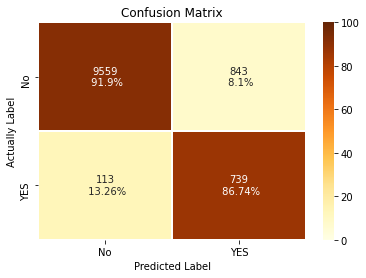

              precision    recall  f1-score   support

           0       0.99      0.92      0.95     10402
           1       0.47      0.87      0.61       852

    accuracy                           0.92     11254
   macro avg       0.73      0.89      0.78     11254
weighted avg       0.95      0.92      0.93     11254



In [81]:
plant = 'A.thaliana'
y_true = np.argmax(data[plant]['target'], axis=1)
y_pred =  np.argmax(model.predict(data[plant]['feature']), axis=1)
confusion_matrix(y_true,y_pred,["No","YES"])
print(classification_report(y_true, y_pred))

352/352 [==============================] - 1s 2ms/step


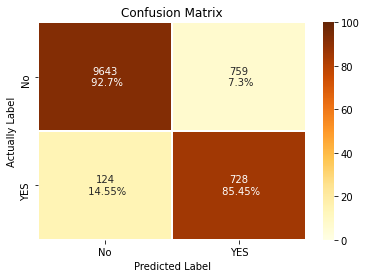

              precision    recall  f1-score   support

           0       0.99      0.93      0.96     10402
           1       0.49      0.85      0.62       852

    accuracy                           0.92     11254
   macro avg       0.74      0.89      0.79     11254
weighted avg       0.95      0.92      0.93     11254



In [76]:
plant = 'A.thaliana'
y_true = np.argmax(data[plant]['target'], axis=1)
y_pred =  np.argmax(model.predict(data[plant]['feature']), axis=1)
confusion_matrix(y_true,y_pred,["No","YES"])
print(classification_report(y_true, y_pred))

# C.Sinensis

73/73 [==============================] - 0s 2ms/step


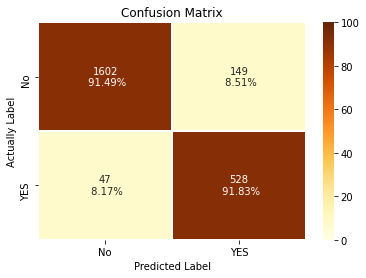

              precision    recall  f1-score   support

           0       0.97      0.91      0.94      1751
           1       0.78      0.92      0.84       575

    accuracy                           0.92      2326
   macro avg       0.88      0.92      0.89      2326
weighted avg       0.92      0.92      0.92      2326



In [23]:
plant = 'C.Sinensis'
y_true = np.argmax(data[plant]['target'], axis=1)
y_pred =  np.argmax(model.predict(data[plant]['feature']), axis=1)
confusion_matrix(y_true,y_pred,["No","YES"])
print(classification_report(y_true, y_pred))

# Z.mays

23/23 [==============================] - 0s 2ms/step


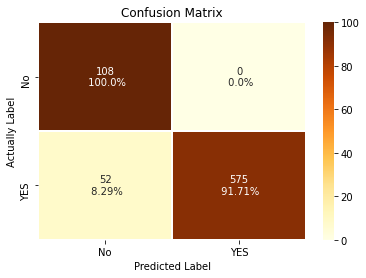

              precision    recall  f1-score   support

           0       0.68      1.00      0.81       108
           1       1.00      0.92      0.96       627

    accuracy                           0.93       735
   macro avg       0.84      0.96      0.88       735
weighted avg       0.95      0.93      0.93       735



In [36]:
plant = 'Z.mays'
y_true = np.argmax(data[plant]['target'], axis=1)
y_pred =  np.argmax(model.predict(data[plant]['feature']), axis=1)
confusion_matrix(y_true,y_pred,["No","YES"])
print(classification_report(y_true, y_pred))